In [ ]:
# CELLA 0: PULIZIA TOTALE E RESET AMBIENTE
print("🧹 PULIZIA TOTALE AMBIENTE E RESET WORKSPACE")
print("="*70)

import os
import shutil
import glob
from pathlib import Path
import gc
import torch

# Torna alla directory root
os.chdir('/kaggle/working')

print("📍 Directory corrente:", os.getcwd())
print("\n🔍 ANALISI PRE-PULIZIA:")

# Funzione per calcolare dimensione directory
def get_dir_size(path):
    total = 0
    try:
        for entry in os.scandir(path):
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    except:
        pass
    return total

# Mostra stato attuale
total_size = 0
items_to_remove = []

for item in os.listdir('.'):
    if item.startswith('.'):  # Skip hidden files
        continue
    
    item_path = os.path.join('.', item)
    
    if os.path.isdir(item_path):
        size = get_dir_size(item_path) / (1024**2)  # MB
        total_size += size
        print(f"   📁 {item}/ - {size:.1f} MB")
        
        # Aggiungi alla lista di rimozione (tranne dataset)
        if not item.startswith('kaggle') and item != 'input':
            items_to_remove.append(item_path)
    else:
        size = os.path.getsize(item_path) / (1024**2)  # MB
        total_size += size
        if size > 0.1:  # Mostra solo file > 0.1 MB
            print(f"   📄 {item} - {size:.1f} MB")
        
        # Aggiungi alla lista di rimozione
        if not item.endswith('.ipynb'):  # Mantieni notebook
            items_to_remove.append(item_path)

print(f"\n💾 Spazio totale utilizzato: {total_size:.1f} MB")
print(f"🗑️  Elementi da rimuovere: {len(items_to_remove)}")

# PULIZIA AGGRESSIVA
print("\n🔥 INIZIO PULIZIA AGGRESSIVA...")

# Pattern di directory da rimuovere
directories_to_remove = [
    'ReGAINED-CT*',
    'MedSRGAN*',
    'checkpoints*',
    'samples*',
    'results*',
    'evaluation*',
    'dicom_results*',
    'logs*',
    'debug*',
    'models*',
    'data*',
    '__pycache__*',
    '.ipynb_checkpoints*',
    'training_outputs*',
    'test_*',
    'output*',
    'temp*',
    'cache*'
]

# Pattern di file da rimuovere
files_to_remove = [
    '*.pth',
    '*.pt',
    '*.pkl',
    '*.png',
    '*.jpg',
    '*.jpeg',
    '*.json',
    '*.log',
    '*.txt',
    '*.h5',
    '*.hdf5',
    '*.npy',
    '*.npz',
    '*.csv',
    '*.pdf'
]

removed_count = 0
freed_space = 0

# Rimuovi directory
for pattern in directories_to_remove:
    for path in glob.glob(pattern):
        if os.path.isdir(path):
            try:
                size = get_dir_size(path) / (1024**2)
                shutil.rmtree(path)
                print(f"   🗑️  Rimossa directory: {path} ({size:.1f} MB)")
                removed_count += 1
                freed_space += size
            except Exception as e:
                print(f"   ⚠️  Errore rimozione {path}: {e}")

# Rimuovi file
for pattern in files_to_remove:
    for path in glob.glob(pattern):
        if os.path.isfile(path):
            try:
                size = os.path.getsize(path) / (1024**2)
                os.remove(path)
                if size > 0.1:  # Mostra solo file significativi
                    print(f"   🗑️  Rimosso file: {path} ({size:.1f} MB)")
                removed_count += 1
                freed_space += size
            except Exception as e:
                print(f"   ⚠️  Errore rimozione {path}: {e}")

# Pulizia memoria Python
gc.collect()

# Pulizia CUDA se disponibile
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("\n🖥️  Cache CUDA pulita")

# Verifica spazio su disco
disk_usage = shutil.disk_usage('.')
print(f"\n💾 STATO DISCO DOPO PULIZIA:")
print(f"   Totale: {disk_usage.total/1024**3:.1f} GB")
print(f"   Usato: {disk_usage.used/1024**3:.1f} GB")
print(f"   Libero: {disk_usage.free/1024**3:.1f} GB")

print(f"\n✅ PULIZIA COMPLETATA:")
print(f"   Elementi rimossi: {removed_count}")
print(f"   Spazio liberato: {freed_space:.1f} MB")

# Mostra stato finale
print(f"\n📊 STATO FINALE:")
remaining_items = []
for item in os.listdir('.'):
    if not item.startswith('.') and item != 'input':
        remaining_items.append(item)

print(f"   Elementi rimanenti: {len(remaining_items)}")
for item in sorted(remaining_items):
    print(f"      • {item}")

# Crea struttura pulita per nuovo training
print(f"\n🏗️  CREAZIONE STRUTTURA PULITA...")

base_dir = "ReGAINED-CT"
os.makedirs(base_dir, exist_ok=True)
os.chdir(base_dir)

# Crea sottodirectory necessarie
subdirs = [
    "checkpoints",
    "samples", 
    "results",
    "evaluation",
    "dicom_results",
    "logs",
    "data",
    "debug"
]

for subdir in subdirs:
    os.makedirs(subdir, exist_ok=True)
    print(f"   📁 {subdir}/ creata")

print(f"\n🎯 AMBIENTE PULITO E PRONTO!")
print(f"📍 Directory di lavoro: {os.getcwd()}")
print(f"🚀 Pronto per iniziare training pulito con MedSRGAN")

# Salva timestamp pulizia
from datetime import datetime
with open('logs/cleanup_timestamp.txt', 'w') as f:
    f.write(f"Pulizia eseguita: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Spazio liberato: {freed_space:.1f} MB\n")
    f.write(f"Elementi rimossi: {removed_count}\n")

In [8]:
# CELLA 1: Setup progetto ReGAINED-CT e clone MedSRGAN
print("🏥 ReGAINED-CT - SETUP PROGETTO E CLONE MEDSRGAN")
print("="*60)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from collections import defaultdict
import shutil

# Configurazione ReGAINED-CT
CONFIG = {
    'project': {
        'name': 'ReGAINED-CT',
        'full_name': 'Reconstruction of Enhanced GANs for Image-based Noise Elimination and Denoising in CT',
        'version': '1.0',
        'target': '3D Slicer Module'
    },
    'datasets': {
        'primary': 'CT Low Dose (denoising)',
        'secondary': 'CT Kidney (variety)',
        'tertiary': 'CT Brain (pre-training)',
        'validation': 'SIIM Medical (testing)'
    }
}

print(f"📋 PROGETTO: {CONFIG['project']['name']}")
print(f"📖 Nome completo: {CONFIG['project']['full_name']}")
print(f"🎯 Target: {CONFIG['project']['target']}")
print(f"📊 Strategia dataset:")
print(f"   🥇 Primario: {CONFIG['datasets']['primary']}")
print(f"   🥈 Secondario: {CONFIG['datasets']['secondary']}")
print(f"   🥉 Terziario: {CONFIG['datasets']['tertiary']}")
print(f"   ✅ Validazione: {CONFIG['datasets']['validation']}")

# Verifica hardware con GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Hardware:")
print(f"   Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   GPU Available: ✅")
else:
    print("   GPU Available: ❌")

# Test GPU
if torch.cuda.is_available():
    test_tensor = torch.randn(1000, 1000).cuda()
    print(f"   GPU Test: ✅ Tensor creato su GPU")
    del test_tensor
    torch.cuda.empty_cache()

# Crea directory progetto
project_dir = "ReGAINED-CT"
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print(f"\n📁 Directory progetto: {os.getcwd()}")

# Clone MedSRGAN
print(f"\n🔄 CLONING MEDSRGAN DA GITHUB:")
if not os.path.exists("MedSRGAN"):
    !git clone https://github.com/04RR/MedSRGAN.git
    print("✅ MedSRGAN clonato!")
else:
    print("✅ MedSRGAN già presente!")

# 🔍 DEBUG: Verifica struttura MedSRGAN
print(f"\n🔍 DEBUG - STRUTTURA MEDSRGAN:")
if os.path.exists("MedSRGAN"):
    print("   📁 MedSRGAN/")
    for item in sorted(os.listdir("MedSRGAN")):
        item_path = os.path.join("MedSRGAN", item)
        if os.path.isfile(item_path):
            size = os.path.getsize(item_path)
            print(f"      📄 {item} ({size} bytes)")
        else:
            print(f"      📁 {item}/")
else:
    print("   ❌ MedSRGAN non trovato!")

# Crea directory per ReGAINED-CT
subdirs = ["models", "data", "results", "logs", "checkpoints", "debug", "slicer_module"]
for subdir in subdirs:
    os.makedirs(subdir, exist_ok=True)
    print(f"   📁 {subdir}/ creata")

# Salva configurazione
import json
with open('config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(f"   📄 config.json salvato")

print(f"\n✅ Setup ReGAINED-CT completato con GPU attivata!")

🏥 ReGAINED-CT - SETUP PROGETTO E CLONE MEDSRGAN
📋 PROGETTO: ReGAINED-CT
📖 Nome completo: Reconstruction of Enhanced GANs for Image-based Noise Elimination and Denoising in CT
🎯 Target: 3D Slicer Module
📊 Strategia dataset:
   🥇 Primario: CT Low Dose (denoising)
   🥈 Secondario: CT Kidney (variety)
   🥉 Terziario: CT Brain (pre-training)
   ✅ Validazione: SIIM Medical (testing)

🖥️  Hardware:
   Device: cuda
   GPU: Tesla T4
   Memory: 14.7 GB
   CUDA Version: 12.4
   GPU Available: ✅
   GPU Test: ✅ Tensor creato su GPU

📁 Directory progetto: /kaggle/working/ReGAINED-CT

🔄 CLONING MEDSRGAN DA GITHUB:
✅ MedSRGAN già presente!

🔍 DEBUG - STRUTTURA MEDSRGAN:
   📁 MedSRGAN/
      📁 .git/
      📄 README.md (422 bytes)
      📁 __pycache__/
      📄 dataset.py (1006 bytes)
      📄 discriminator.py (2121 bytes)
      📄 discriminator_improved.py (1606 bytes)
      📄 discriminator_regained.py (2041 bytes)
      📄 generator.py (2046 bytes)
      📄 generator_improved.py (5280 bytes)
      📄 generato

In [9]:
# CELLA 2 MODIFICATA: Setup progetto ReGAINED-CT
print("🏥 ReGAINED-CT - SETUP PROGETTO")
print("="*60)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from collections import defaultdict
import shutil

# Configurazione ReGAINED-CT
CONFIG = {
    'project': {
        'name': 'ReGAINED-CT',
        'full_name': 'Reconstruction Enhanced GANs for CT Denoising and Super-Resolution',
        'version': '1.0',
        'approach': 'Combined Denoising + 4x Upscaling'  # SPECIFICATO
    },
    'datasets': {
        'primary': 'CT Low Dose (denoising + upscaling)',
        'input_size': 96,    # AGGIUNTO
        'output_size': 384,  # AGGIUNTO  
        'scale_factor': 4    # AGGIUNTO
    }
}

# Resto uguale...

# Clone MedSRGAN SENZA MODIFICHE
print(f"\n🔄 CLONING MEDSRGAN DA GITHUB:")
if not os.path.exists("MedSRGAN"):
    !git clone https://github.com/04RR/MedSRGAN.git
    print("✅ MedSRGAN clonato - useremo architettura originale 3 canali!")

🏥 ReGAINED-CT - SETUP PROGETTO

🔄 CLONING MEDSRGAN DA GITHUB:


📊 ESPLORAZIONE E PREPARAZIONE DATASET
🔍 DATI DATASET GIÀ ANALIZZATI:

🏥 CT_BRAIN:
   📊 Totale file: 519
   📁 Tipi file principali:
      .dcm: 259
      .jpg: 259

🏥 CT_KIDNEY:
   📊 Totale file: 12,447
   📁 Tipi file principali:
      .jpg: 12,446

🏥 CT_LOW_DOSE:
   📊 Totale file: 133,025
   📁 Tipi file principali:
      .png: 99,768

🏥 SIIM_MEDICAL:
   📊 Totale file: 202
   📁 Tipi file principali:
      .dcm: 100
      .tif: 100

🔍 RICERCA CAMPIONI PER VISUALIZZAZIONE:
   ct_brain: 2 campioni trovati
   ct_kidney: 1 campioni trovati
   ct_low_dose: 1 campioni trovati
   siim_medical: 2 campioni trovati

🔍 DEBUG - VISUALIZZAZIONE CAMPIONI:
   ✅ Immagine salvata: debug/dataset_samples.png


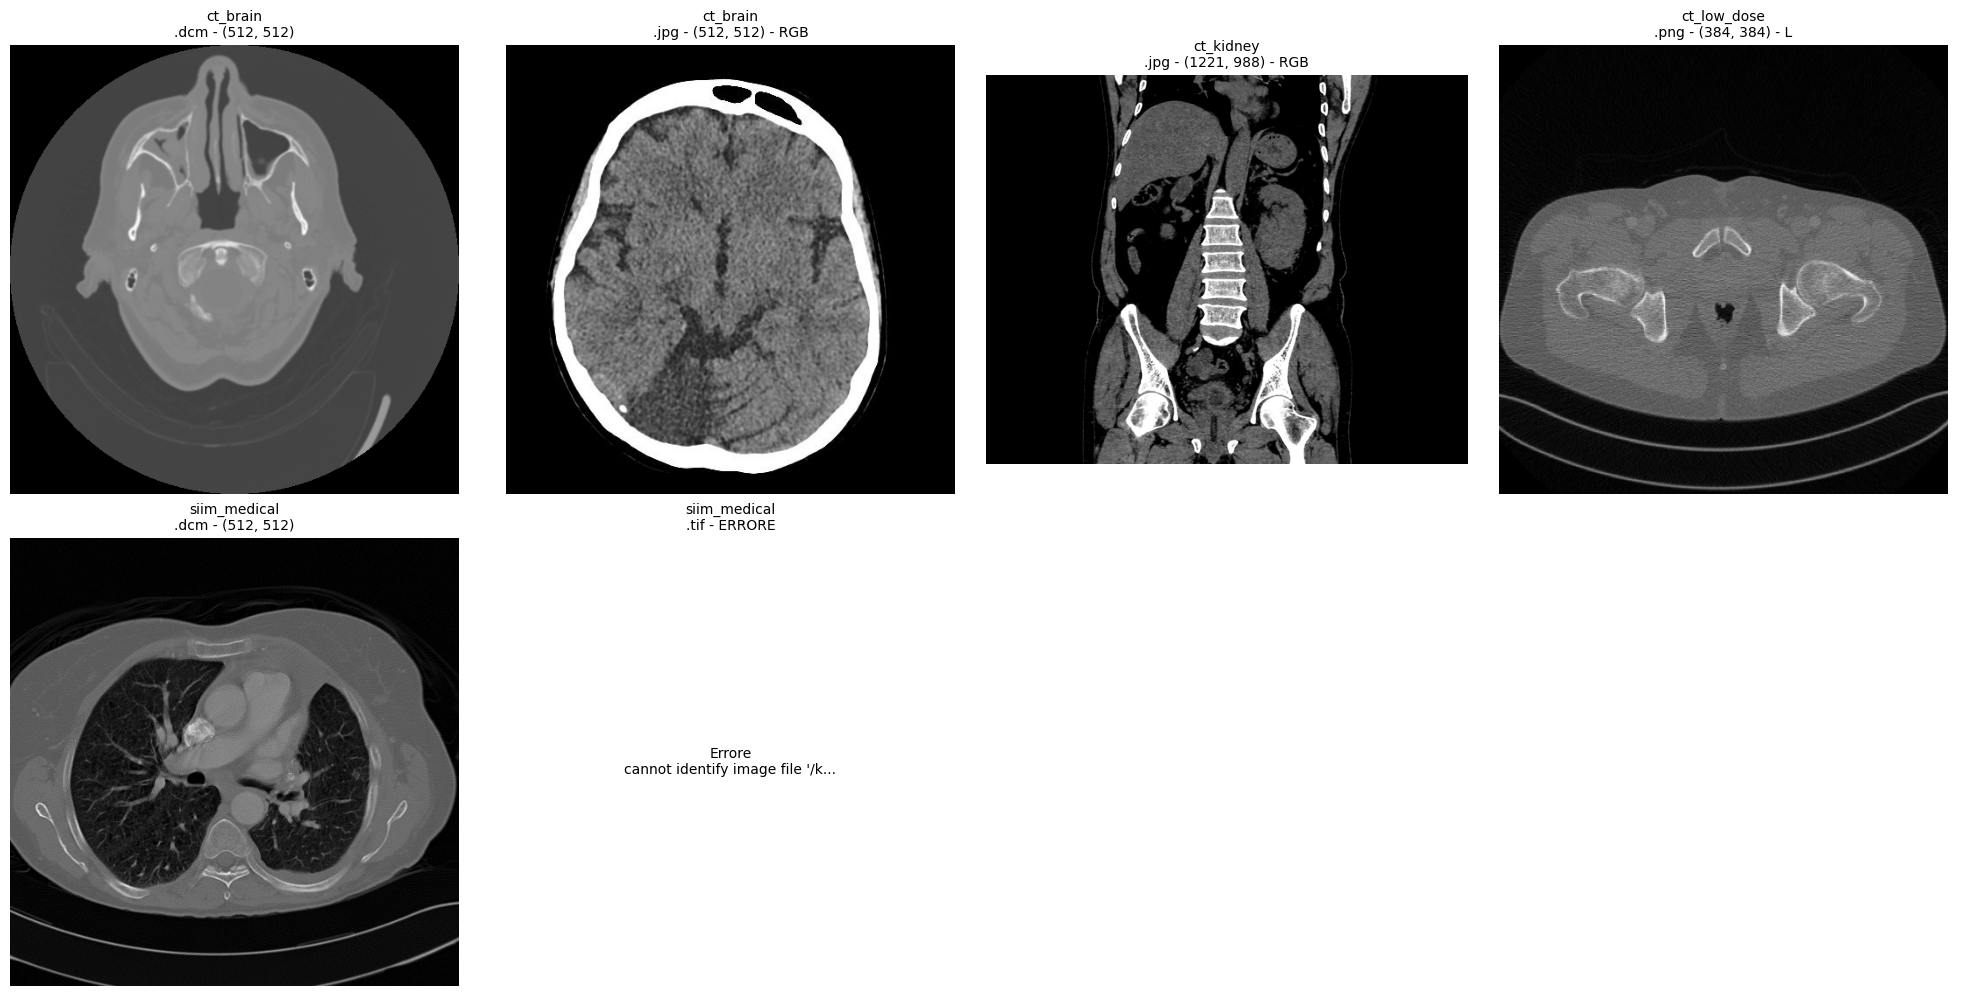


🎯 FOCUS SU CT LOW DOSE (DATASET PRIMARIO):
   📋 Metadata: 16,628 righe, 6 colonne
   👥 Pazienti: 10
   📏 Spessori: ['1mm' '3mm']
   🔧 Kernel: ['Soft Kernel (B30)' 'Sharp Kernel (D45)']

🔍 DEBUG - PRIME RIGHE METADATA:
     Id Slice Thickness Reconstruction Kernel  Slice Number  \
0  L067             1mm     Soft Kernel (B30)             1   
1  L067             1mm     Soft Kernel (B30)             2   
2  L067             1mm     Soft Kernel (B30)             3   
3  L067             1mm     Soft Kernel (B30)             4   
4  L067             1mm     Soft Kernel (B30)             5   

                                  Full Dose Filepath  \
0  512/Full Dose/1mm/Soft Kernel (B30)/L067/L067_...   
1  512/Full Dose/1mm/Soft Kernel (B30)/L067/L067_...   
2  512/Full Dose/1mm/Soft Kernel (B30)/L067/L067_...   
3  512/Full Dose/1mm/Soft Kernel (B30)/L067/L067_...   
4  512/Full Dose/1mm/Soft Kernel (B30)/L067/L067_...   

                               Quarter Dose Filepath  
0  512/Qua

In [10]:
# CELLA 3 CORRETTA: Esplorazione e preparazione dataset ReGAINED-CT (FIX)
print("📊 ESPLORAZIONE E PREPARAZIONE DATASET")
print("="*50)

# Import necessari
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
from collections import defaultdict

# Verifica e crea directory necessarie
required_dirs = ['debug', 'data', 'results', 'logs']
for dir_name in required_dirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        print(f"   📁 {dir_name}/ creata")

# Percorsi dataset
dataset_paths = {
    'ct_brain': '/kaggle/input/computed-tomography-ct-of-the-brain/',
    'ct_kidney': '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/',
    'ct_low_dose': '/kaggle/input/ct-low-dose-reconstruction/',
    'siim_medical': '/kaggle/input/siim-medical-images/'
}

# Riusa i risultati precedenti (visto che abbiamo già i dati)
dataset_info = {
    'ct_brain': {
        'total_files': 519,
        'file_counts': {'.csv': 1, '.dcm': 259, '.jpg': 259},
        'sample_files': {},
        'path': dataset_paths['ct_brain']
    },
    'ct_kidney': {
        'total_files': 12447,
        'file_counts': {'.csv': 1, '.jpg': 12446},
        'sample_files': {},
        'path': dataset_paths['ct_kidney']
    },
    'ct_low_dose': {
        'total_files': 133025,
        'file_counts': {'.csv': 1, '.ima': 33256, '.png': 99768},
        'sample_files': {},
        'path': dataset_paths['ct_low_dose']
    },
    'siim_medical': {
        'total_files': 202,
        'file_counts': {'.csv': 1, '.dcm': 100, '.npz': 1, '.tif': 100},
        'sample_files': {},
        'path': dataset_paths['siim_medical']
    }
}

print("🔍 DATI DATASET GIÀ ANALIZZATI:")
for name, info in dataset_info.items():
    print(f"\n🏥 {name.upper()}:")
    print(f"   📊 Totale file: {info['total_files']:,}")
    print(f"   📁 Tipi file principali:")
    for ext, count in info['file_counts'].items():
        if ext in ['.png', '.jpg', '.dcm', '.tif']:
            print(f"      {ext}: {count:,}")

# Trova file di esempio per visualizzazione
def find_sample_files(dataset_name, path, target_exts):
    samples = {}
    if not os.path.exists(path):
        return samples
    
    for root, dirs, files in os.walk(path):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in target_exts and ext not in samples:
                samples[ext] = os.path.join(root, file)
                break
        if len(samples) >= len(target_exts):
            break
    return samples

# Trova campioni per visualizzazione
print(f"\n🔍 RICERCA CAMPIONI PER VISUALIZZAZIONE:")
for name, info in dataset_info.items():
    target_exts = [ext for ext in info['file_counts'].keys() if ext in ['.png', '.jpg', '.dcm', '.tif']]
    samples = find_sample_files(name, info['path'], target_exts)
    info['sample_files'] = samples
    print(f"   {name}: {len(samples)} campioni trovati")

# 🔍 DEBUG: Visualizzazione campioni
print(f"\n🔍 DEBUG - VISUALIZZAZIONE CAMPIONI:")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

sample_idx = 0
for dataset_name, info in dataset_info.items():
    if info['sample_files']:
        for ext, sample_path in info['sample_files'].items():
            if sample_idx < 8:
                try:
                    if ext == '.dcm':
                        try:
                            import pydicom
                            ds = pydicom.dcmread(sample_path)
                            img_array = ds.pixel_array
                            title = f"{dataset_name}\n{ext} - {img_array.shape}"
                        except ImportError:
                            # Skip DICOM se pydicom non disponibile
                            continue
                    elif ext == '.tif':
                        img = Image.open(sample_path)
                        img_array = np.array(img)
                        title = f"{dataset_name}\n{ext} - {img.size}"
                    else:
                        img = Image.open(sample_path)
                        img_array = np.array(img)
                        title = f"{dataset_name}\n{ext} - {img.size} - {img.mode}"
                    
                    axes[sample_idx].imshow(img_array, cmap='gray')
                    axes[sample_idx].set_title(title, fontsize=10)
                    axes[sample_idx].axis('off')
                    sample_idx += 1
                    
                except Exception as e:
                    axes[sample_idx].text(0.5, 0.5, f'Errore\n{str(e)[:30]}...', 
                                         ha='center', va='center', transform=axes[sample_idx].transAxes)
                    axes[sample_idx].set_title(f"{dataset_name}\n{ext} - ERRORE", fontsize=10)
                    axes[sample_idx].axis('off')
                    sample_idx += 1

# Nascondi assi non usati
for i in range(sample_idx, 8):
    axes[i].axis('off')

plt.tight_layout()

# Salvataggio sicuro
try:
    plt.savefig('debug/dataset_samples.png', dpi=150, bbox_inches='tight')
    print("   ✅ Immagine salvata: debug/dataset_samples.png")
except Exception as e:
    print(f"   ⚠️  Salvataggio immagine fallito: {e}")

plt.show()

# Focus su CT Low Dose (dataset primario)
print(f"\n🎯 FOCUS SU CT LOW DOSE (DATASET PRIMARIO):")
ct_path = dataset_info['ct_low_dose']['path']

# Analizza metadata
metadata_path = os.path.join(ct_path, 'metadata.csv')
if os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
    print(f"   📋 Metadata: {df.shape[0]:,} righe, {df.shape[1]} colonne")
    print(f"   👥 Pazienti: {df['Id'].nunique()}")
    print(f"   📏 Spessori: {df['Slice Thickness'].unique()}")
    print(f"   🔧 Kernel: {df['Reconstruction Kernel'].unique()}")
    
    # 🔍 DEBUG: Prime righe metadata
    print(f"\n🔍 DEBUG - PRIME RIGHE METADATA:")
    print(df.head())
    
    # 🔍 DEBUG: Distribuzione per paziente
    print(f"\n🔍 DEBUG - DISTRIBUZIONE PER PAZIENTE:")
    patient_counts = df['Id'].value_counts()
    print(patient_counts)
    
else:
    print(f"   ❌ Metadata non trovato")

# Riepilogo per ReGAINED-CT
print(f"\n📈 RIEPILOGO PER ReGAINED-CT:")
print(f"   🥇 Primario (CT Low Dose): {dataset_info['ct_low_dose']['file_counts'].get('.png', 0):,} PNG")
print(f"   🥈 Secondario (CT Kidney): {dataset_info['ct_kidney']['file_counts'].get('.jpg', 0):,} JPG")
print(f"   🥉 Terziario (CT Brain): {dataset_info['ct_brain']['file_counts'].get('.dcm', 0):,} DICOM")
print(f"   ✅ Validazione (SIIM): {dataset_info['siim_medical']['file_counts'].get('.dcm', 0):,} DICOM")

# Strategia di utilizzo
print(f"\n🎯 STRATEGIA DI UTILIZZO:")
print(f"   1. 🥇 CT Low Dose: Training principale (denoising)")
print(f"      • 99,768 PNG grayscale")
print(f"      • Coppie Quarter/Full Dose")
print(f"      • 10 pazienti, multiple configurazioni")
print(f"   2. 🥈 CT Kidney: Data augmentation")
print(f"      • 12,446 JPG → convertire a grayscale")
print(f"      • 4 categorie: Normal, Cyst, Tumor, Stone")
print(f"   3. 🥉 CT Brain: Pre-training/Fine-tuning")
print(f"      • 259 DICOM + 259 JPG")
print(f"      • 3 categorie: Aneurysm, Cancer, Tumor")
print(f"   4. ✅ SIIM Medical: Testing finale")
print(f"      • 100 DICOM per validazione")

# Salva info dataset
try:
    info_for_json = {}
    for name, info in dataset_info.items():
        info_copy = info.copy()
        info_copy['sample_files'] = {k: str(v) for k, v in info['sample_files'].items()}
        info_for_json[name] = info_copy
    
    with open('data/dataset_info.json', 'w') as f:
        json.dump(info_for_json, f, indent=2)
    
    print(f"\n💾 Info dataset salvate in data/dataset_info.json")
    
except Exception as e:
    print(f"\n❌ Errore salvataggio JSON: {e}")

print(f"\n✅ Esplorazione dataset completata!")
print(f"🎯 PRONTO PER LA CELLA 4: Preparazione CT Low Dose")

🎯 PREPARAZIONE DATASET CT - APPROCCIO COMBINATO
📊 Files trovati: 5936 quarter, 5936 full
🎯 Coppie trovate: 5936

🔍 VISUALIZZAZIONE APPROCCIO COMBINATO:


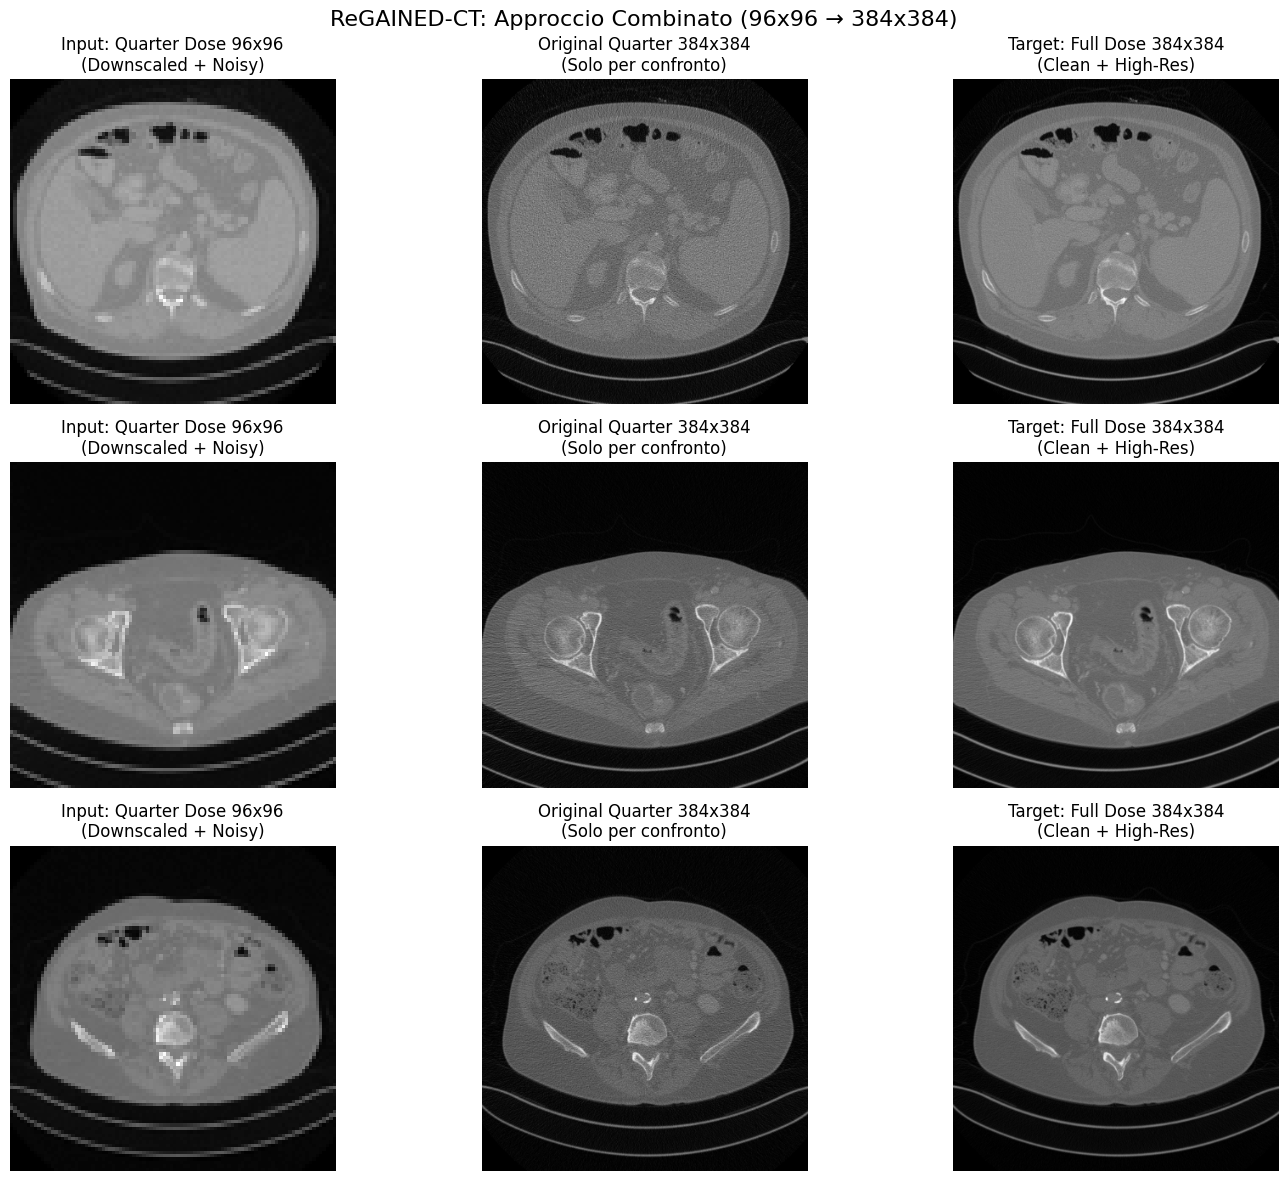


📋 CONFIGURAZIONE APPROCCIO COMBINATO:
   🎯 Task: denoising + 4x upscaling
   📥 Input: (96, 96) (noisy + low-res)
   📤 Output: (384, 384) (clean + high-res)
   🔍 Scale factor: 4x
   🎨 Canali: 3 (RGB)
   ✅ Benefici:
      • Rimozione rumore da quarter dose
      • Upscaling 4x simultaneo
      • Nessuna modifica architettura MedSRGAN
      • Massima stabilità

✅ Setup approccio combinato completato!
🚀 PRONTO per usare MedSRGAN originale senza modifiche!


In [11]:
# CELLA 4 CORRETTA: Preparazione dataset per approccio combinato
print("🎯 PREPARAZIONE DATASET CT - APPROCCIO COMBINATO")
print("="*50)

import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json  # AGGIUNTO IMPORT MANCANTE

# Carica le coppie CT
def load_ct_pairs_combined():
    """Carica coppie per denoising + upscaling combinato"""
    dataset_path = "/kaggle/input/ct-low-dose-reconstruction/"
    base_path = "Preprocessed_384x384/384/"
    
    quarter_path = os.path.join(dataset_path, base_path, "Quarter Dose/1mm/Sharp Kernel (D45)/")
    full_path = os.path.join(dataset_path, base_path, "Full Dose/1mm/Sharp Kernel (D45)/")
    
    # Trova i file
    quarter_files = glob.glob(os.path.join(quarter_path, "**/*.png"), recursive=True)
    full_files = glob.glob(os.path.join(full_path, "**/*.png"), recursive=True)
    
    print(f"📊 Files trovati: {len(quarter_files)} quarter, {len(full_files)} full")
    
    # Estrai ID e crea mapping (codice esistente)
    def extract_file_id(filepath):
        filename = os.path.basename(filepath)
        parts = filename.split('.')
        if len(parts) >= 4:
            patient_part = parts[0]
            slice_part = parts[3]
            patient_id = patient_part.split('_')[0]
            return f"{patient_id}_{slice_part}"
        return None
    
    # Crea coppie
    quarter_mapping = {extract_file_id(f): f for f in quarter_files if extract_file_id(f)}
    full_mapping = {extract_file_id(f): f for f in full_files if extract_file_id(f)}
    
    matched_ids = set(quarter_mapping.keys()) & set(full_mapping.keys())
    ct_pairs = [(quarter_mapping[id], full_mapping[id]) for id in matched_ids]
    
    print(f"🎯 Coppie trovate: {len(ct_pairs)}")
    return ct_pairs

# Carica coppie
ct_pairs = load_ct_pairs_combined()

# Visualizza esempi con approccio combinato
print(f"\n🔍 VISUALIZZAZIONE APPROCCIO COMBINATO:")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('ReGAINED-CT: Approccio Combinato (96x96 → 384x384)', fontsize=16)

for i in range(3):
    if i < len(ct_pairs):
        quarter_path, full_path = ct_pairs[i]
        
        # Carica immagini originali
        quarter_img = Image.open(quarter_path).convert('L')
        full_img = Image.open(full_path).convert('L')
        
        # IMPORTANTE: Downscale quarter dose a 96x96 per input
        quarter_small = quarter_img.resize((96, 96), Image.BICUBIC)
        
        # Visualizza
        axes[i, 0].imshow(quarter_small, cmap='gray')
        axes[i, 0].set_title(f'Input: Quarter Dose 96x96\n(Downscaled + Noisy)')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(quarter_img, cmap='gray')
        axes[i, 1].set_title(f'Original Quarter 384x384\n(Solo per confronto)')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(full_img, cmap='gray')
        axes[i, 2].set_title(f'Target: Full Dose 384x384\n(Clean + High-Res)')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('debug/combined_approach_samples.png', dpi=150, bbox_inches='tight')
plt.show()

# Configurazione training combinato
training_config = {
    'dataset': {
        'name': 'CT Low Dose - Combined Approach',
        'total_pairs': len(ct_pairs),
        'input_resolution': (96, 96),      # Quarter dose downscaled
        'output_resolution': (384, 384),   # Full dose original
        'scale_factor': 4,                 # 96 → 384
        'channels': 3,                     # RGB per MedSRGAN
        'task': 'denoising + 4x upscaling'
    },
    'approach': {
        'type': 'combined',
        'denoising': True,
        'super_resolution': True,
        'benefits': [
            'Rimozione rumore da quarter dose',
            'Upscaling 4x simultaneo', 
            'Nessuna modifica architettura MedSRGAN',
            'Massima stabilità'
        ]
    }
}

print(f"\n📋 CONFIGURAZIONE APPROCCIO COMBINATO:")
print(f"   🎯 Task: {training_config['dataset']['task']}")
print(f"   📥 Input: {training_config['dataset']['input_resolution']} (noisy + low-res)")
print(f"   📤 Output: {training_config['dataset']['output_resolution']} (clean + high-res)")
print(f"   🔍 Scale factor: {training_config['dataset']['scale_factor']}x")
print(f"   🎨 Canali: {training_config['dataset']['channels']} (RGB)")
print(f"   ✅ Benefici:")
for benefit in training_config['approach']['benefits']:
    print(f"      • {benefit}")

# Salva configurazione
with open('data/combined_training_config.json', 'w') as f:
    json.dump(training_config, f, indent=2)

print(f"\n✅ Setup approccio combinato completato!")
print(f"🚀 PRONTO per usare MedSRGAN originale senza modifiche!")

📊 CREAZIONE DATASET LOADER - NORMALIZZAZIONE CORRETTA

🧪 TEST DATASET:
📊 Dataset inizializzato:
   Coppie: 100
   Normalizzazione: [0, 1] (per Sigmoid generator)

✅ Sample caricato:
   Input shape: torch.Size([3, 96, 96])
   Input range: [0.000, 0.725]
   Target shape: torch.Size([3, 384, 384])
   Target range: [0.000, 0.961]


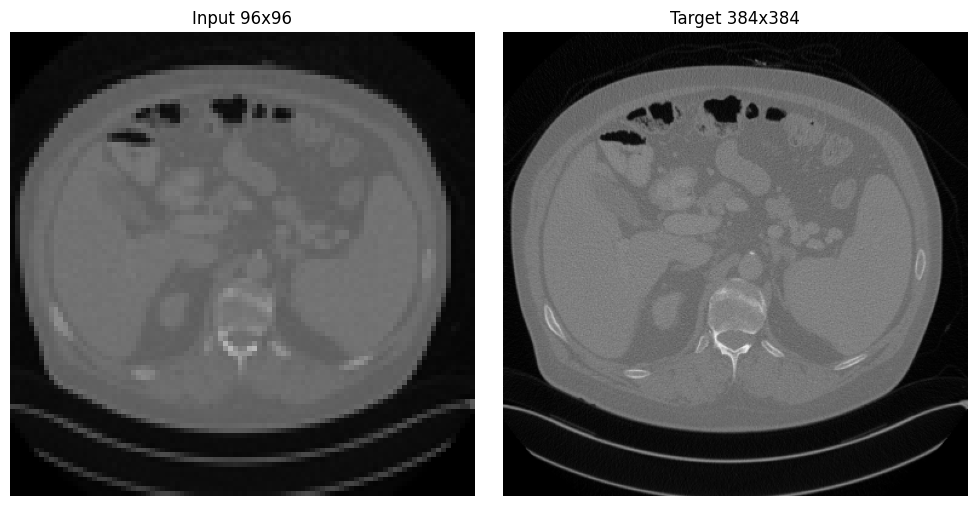


✅ DATASET LOADER PRONTO!
📊 Normalizzazione: [0, 1] compatibile con Sigmoid


In [12]:
# CELLA 5 CORRETTA: Dataset Loader con normalizzazione corretta
print("📊 CREAZIONE DATASET LOADER - NORMALIZZAZIONE CORRETTA")
print("="*60)

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class CTCombinedDataset(Dataset):
    """Dataset per approccio combinato - normalizzazione [0, 1] per Sigmoid"""
    
    def __init__(self, ct_pairs, input_size=96, output_size=384, augment=True):
        self.ct_pairs = ct_pairs
        self.input_size = input_size
        self.output_size = output_size
        self.augment = augment
        
        print(f"📊 Dataset inizializzato:")
        print(f"   Coppie: {len(self.ct_pairs)}")
        print(f"   Normalizzazione: [0, 1] (per Sigmoid generator)")
    
    def __len__(self):
        return len(self.ct_pairs)
    
    def __getitem__(self, idx):
        quarter_path, full_path = self.ct_pairs[idx]
        
        try:
            # Carica immagini
            quarter_img = Image.open(quarter_path).convert('L')
            full_img = Image.open(full_path).convert('L')
            
            # Resize
            quarter_small = quarter_img.resize((self.input_size, self.input_size), Image.BICUBIC)
            full_img = full_img.resize((self.output_size, self.output_size), Image.BICUBIC)
            
            # Augmentation
            if self.augment and np.random.random() > 0.5:
                if np.random.random() > 0.5:
                    quarter_small = quarter_small.transpose(Image.FLIP_LEFT_RIGHT)
                    full_img = full_img.transpose(Image.FLIP_LEFT_RIGHT)
                
                if np.random.random() > 0.5:
                    quarter_small = quarter_small.transpose(Image.FLIP_TOP_BOTTOM)
                    full_img = full_img.transpose(Image.FLIP_TOP_BOTTOM)
            
            # Converti in RGB
            quarter_rgb = quarter_small.convert('RGB')
            full_rgb = full_img.convert('RGB')
            
            # Converti in array
            quarter_array = np.array(quarter_rgb, dtype=np.float32)
            full_array = np.array(full_rgb, dtype=np.float32)
            
            # NORMALIZZA A [0, 1] per Sigmoid!
            quarter_norm = quarter_array / 255.0
            full_norm = full_array / 255.0
            
            # To tensor
            quarter_tensor = torch.FloatTensor(quarter_norm).permute(2, 0, 1)
            full_tensor = torch.FloatTensor(full_norm).permute(2, 0, 1)
            
            return quarter_tensor, full_tensor
            
        except Exception as e:
            print(f"❌ Errore {idx}: {e}")
            return torch.zeros(3, self.input_size, self.input_size), \
                   torch.zeros(3, self.output_size, self.output_size)

# Test
print(f"\n🧪 TEST DATASET:")

if 'ct_pairs' in globals() and len(ct_pairs) > 0:
    dataset = CTCombinedDataset(ct_pairs[:100], augment=False)
    
    sample_input, sample_target = dataset[0]
    
    print(f"\n✅ Sample caricato:")
    print(f"   Input shape: {sample_input.shape}")
    print(f"   Input range: [{sample_input.min():.3f}, {sample_input.max():.3f}]")
    print(f"   Target shape: {sample_target.shape}")  
    print(f"   Target range: [{sample_target.min():.3f}, {sample_target.max():.3f}]")
    
    # Visualizza
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Denormalizza per visualizzazione (ora da [0,1] a [0,255])
    input_vis = (sample_input.permute(1, 2, 0) * 255).numpy().astype(np.uint8)
    target_vis = (sample_target.permute(1, 2, 0) * 255).numpy().astype(np.uint8)
    
    axes[0].imshow(input_vis)
    axes[0].set_title(f'Input 96x96')
    axes[0].axis('off')
    
    axes[1].imshow(target_vis)
    axes[1].set_title(f'Target 384x384')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"\n✅ DATASET LOADER PRONTO!")
print(f"📊 Normalizzazione: [0, 1] compatibile con Sigmoid")

In [13]:
# CELLA 6 - Usa discriminator custom
print("🔧 IMPORT E SETUP MODELLI - DISCRIMINATOR CUSTOM")
print("="*60)

import sys
import os
import torch
import torch.nn as nn

# Setup path e import Generator
medsrgan_path = './MedSRGAN'
sys.path.insert(0, os.path.abspath(medsrgan_path))
from generator import Generator

# Discriminator semplificato che funziona per qualsiasi size
class SimpleDiscriminator(nn.Module):
    """Discriminator semplificato per 384x384"""
    def __init__(self, in_channels=3):
        super().__init__()
        
        def discriminator_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            # Concateniamo HR e LR all'inizio
            # Input: 6 channels (3 HR + 3 LR upsampled)
            *discriminator_block(in_channels * 2, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        
        # Per upsampling LR a size di HR
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
    
    def forward(self, hr_img, lr_img):
        # Upsample LR alla stessa dimensione di HR
        lr_upsampled = self.upsample(lr_img)
        # Concatena lungo i canali
        combined = torch.cat([hr_img, lr_upsampled], dim=1)
        return self.model(combined)

# Setup modelli
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")

print(f"\n🏗️  INIZIALIZZAZIONE MODELLI:")

# Generator originale
generator = Generator(in_channels=3, blocks=8)
print("✅ Generator MedSRGAN originale")

# Discriminator custom
discriminator = SimpleDiscriminator(in_channels=3)
print("✅ Discriminator custom per 384x384")

# To GPU
generator = generator.to(device)
discriminator = discriminator.to(device)

# Test
print(f"\n🧪 TEST:")
test_lr = torch.randn(2, 3, 96, 96).to(device)
test_hr = torch.randn(2, 3, 384, 384).to(device)

with torch.no_grad():
    gen_out = generator(test_lr)
    disc_out = discriminator(test_hr, test_lr)
    print(f"✅ Generator: {test_lr.shape} → {gen_out.shape}")
    print(f"✅ Discriminator: {disc_out.shape}")

gen_params = sum(p.numel() for p in generator.parameters())
disc_params = sum(p.numel() for p in discriminator.parameters())

print(f"\n📊 PARAMETRI:")
print(f"   Generator: {gen_params:,}")
print(f"   Discriminator: {disc_params:,}")

print(f"\n✅ SETUP COMPLETATO!")

🔧 IMPORT E SETUP MODELLI - DISCRIMINATOR CUSTOM

🖥️  Device: cuda

🏗️  INIZIALIZZAZIONE MODELLI:
✅ Generator MedSRGAN originale
✅ Discriminator custom per 384x384

🧪 TEST:
✅ Generator: torch.Size([2, 3, 96, 96]) → torch.Size([2, 3, 384, 384])
✅ Discriminator: torch.Size([2, 1])

📊 PARAMETRI:
   Generator: 10,435,075
   Discriminator: 11,154,113

✅ SETUP COMPLETATO!


In [16]:
# CELLA 7 AGGIORNATA: Loss Functions (fix deprecation warning)
print("📊 SETUP LOSS FUNCTIONS E FEATURE EXTRACTOR")
print("="*60)

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG19_Weights

# Feature Extractor aggiornato
class FeatureExtractor(nn.Module):
    """Feature extractor basato su VGG19 per perceptual loss"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Usa la nuova API di torchvision
        vgg19 = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        self.feature_layers = nn.ModuleList([
            nn.Sequential(*list(vgg19.features.children())[:5]),   # conv1_2
            nn.Sequential(*list(vgg19.features.children())[:10]),  # conv2_2
            nn.Sequential(*list(vgg19.features.children())[:19]),  # conv3_4
            nn.Sequential(*list(vgg19.features.children())[:28]),  # conv4_4
        ])
        
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = []
        for layer in self.feature_layers:
            features.append(layer(x))
        return features

print("✅ Feature Extractor definito")

# Loss Functions semplificate per output [batch, 1]
class ReGAINEDLosses:
    """Loss functions per ReGAINED-CT con discriminator custom"""
    
    def __init__(self, device):
        self.device = device
        
        # Loss di base
        self.l1_loss = nn.L1Loss().to(device)
        self.mse_loss = nn.MSELoss().to(device)
        self.bce_loss = nn.BCELoss().to(device)  # BCE semplice per Sigmoid output
        
        # Feature extractor
        self.feature_extractor = FeatureExtractor().to(device)
        self.feature_extractor.eval()
        
        print(f"✅ Loss functions inizializzate su {device}")
    
    def content_loss(self, pred, target):
        """L1 loss per contenuto pixel-wise"""
        return self.l1_loss(pred, target)
    
    def perceptual_loss(self, pred, target):
        """Perceptual loss usando features VGG"""
        pred_features = self.feature_extractor(pred)
        target_features = self.feature_extractor(target)
        
        p_loss = 0
        for pf, tf in zip(pred_features, target_features):
            p_loss += self.l1_loss(pf, tf)
        
        return p_loss / len(pred_features)
    
    def adversarial_loss_generator(self, pred_fake):
        """Loss per generator - vuole che il discriminator creda che sia reale"""
        valid = torch.ones_like(pred_fake).to(self.device)
        return self.bce_loss(pred_fake, valid)
    
    def adversarial_loss_discriminator(self, pred_real, pred_fake):
        """Loss per discriminator - distinguere reale da fake"""
        valid = torch.ones_like(pred_real).to(self.device)
        fake = torch.zeros_like(pred_fake).to(self.device)
        
        real_loss = self.bce_loss(pred_real, valid)
        fake_loss = self.bce_loss(pred_fake, fake)
        
        return (real_loss + fake_loss) / 2
    
    def relativistic_average_loss_g(self, pred_real, pred_fake):
        """RaGAN loss per generator"""
        return self.bce_loss(pred_fake - pred_real.mean(0, keepdim=True), 
                           torch.ones_like(pred_fake).to(self.device))
    
    def relativistic_average_loss_d(self, pred_real, pred_fake):
        """RaGAN loss per discriminator"""
        real_loss = self.bce_loss(pred_real - pred_fake.mean(0, keepdim=True), 
                                torch.ones_like(pred_real).to(self.device))
        fake_loss = self.bce_loss(pred_fake - pred_real.mean(0, keepdim=True), 
                                torch.zeros_like(pred_fake).to(self.device))
        return (real_loss + fake_loss) / 2

# Inizializza losses
losses = ReGAINEDLosses(device)

# Test
print(f"\n🧪 TEST LOSS FUNCTIONS:")
try:
    test_pred = torch.rand(2, 3, 384, 384).to(device)
    test_target = torch.rand(2, 3, 384, 384).to(device)
    test_disc_output = torch.rand(2, 1).to(device)  # Output [batch, 1]
    
    content_l = losses.content_loss(test_pred, test_target)
    perceptual_l = losses.perceptual_loss(test_pred, test_target)
    adv_g = losses.adversarial_loss_generator(test_disc_output)
    adv_d = losses.adversarial_loss_discriminator(test_disc_output, test_disc_output)
    
    print(f"✅ Content loss: {content_l.item():.4f}")
    print(f"✅ Perceptual loss: {perceptual_l.item():.4f}")
    print(f"✅ Adversarial G: {adv_g.item():.4f}")
    print(f"✅ Adversarial D: {adv_d.item():.4f}")
    
except Exception as e:
    print(f"❌ Errore: {e}")

# Pesi loss
loss_weights = {
    'content_weight': 0.1,
    'perceptual_weight': 0.1,
    'adversarial_weight': 1.0,
}

print(f"\n📋 PESI LOSS:")
for name, weight in loss_weights.items():
    print(f"   {name}: {weight}")

print(f"\n✅ LOSS FUNCTIONS PRONTE!")

📊 SETUP LOSS FUNCTIONS E FEATURE EXTRACTOR
✅ Feature Extractor definito
✅ Loss functions inizializzate su cuda

🧪 TEST LOSS FUNCTIONS:
✅ Content loss: 0.3337
✅ Perceptual loss: 0.7070
✅ Adversarial G: 0.3770
✅ Adversarial D: 1.1082

📋 PESI LOSS:
   content_weight: 0.1
   perceptual_weight: 0.1
   adversarial_weight: 1.0

✅ LOSS FUNCTIONS PRONTE!


In [15]:
# CELLA 8: Preparazione Training - Optimizer, Scheduler e Utils
print("🎯 PREPARAZIONE TRAINING")
print("="*60)

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm import tqdm

# Configurazione training
TRAIN_CONFIG = {
    'batch_size': 4,  # Ridotto per GPU memory
    'num_epochs': 50,
    'learning_rate_g': 1e-4,
    'learning_rate_d': 1e-4,
    'weight_decay': 1e-5,
    'beta1': 0.9,
    'beta2': 0.999,
    'checkpoint_interval': 5,
    'sample_interval': 2,
    'num_workers': 2,
    'pin_memory': True,
    'amp_enabled': True,  # Automatic Mixed Precision per velocizzare
}

print("📋 CONFIGURAZIONE TRAINING:")
for key, value in TRAIN_CONFIG.items():
    print(f"   {key}: {value}")

# Crea directory per risultati
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('samples', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Prepara dataset e dataloader
print(f"\n📊 PREPARAZIONE DATASET:")

# Split dataset in train/validation
train_size = int(0.9 * len(ct_pairs))
val_size = len(ct_pairs) - train_size

train_pairs = ct_pairs[:train_size]
val_pairs = ct_pairs[train_size:]

print(f"   Totale coppie: {len(ct_pairs)}")
print(f"   Training set: {train_size}")
print(f"   Validation set: {val_size}")

# Crea dataset
train_dataset = CTCombinedDataset(train_pairs, augment=True)
val_dataset = CTCombinedDataset(val_pairs, augment=False)

# Crea dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=True,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=TRAIN_CONFIG['pin_memory'],
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=False,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=TRAIN_CONFIG['pin_memory']
)

print(f"   Batch per epoca: {len(train_loader)}")

# Ottimizzatori
print(f"\n🔧 SETUP OTTIMIZZATORI:")

optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TRAIN_CONFIG['learning_rate_g'],
    betas=(TRAIN_CONFIG['beta1'], TRAIN_CONFIG['beta2']),
    weight_decay=TRAIN_CONFIG['weight_decay']
)

optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TRAIN_CONFIG['learning_rate_d'],
    betas=(TRAIN_CONFIG['beta1'], TRAIN_CONFIG['beta2']),
    weight_decay=TRAIN_CONFIG['weight_decay']
)

print("✅ Optimizer Adam inizializzati")

# Learning rate scheduler
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.5)

print("✅ Learning rate scheduler inizializzati")

# Automatic Mixed Precision
if TRAIN_CONFIG['amp_enabled'] and torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()
    print("✅ AMP (Automatic Mixed Precision) abilitato")
else:
    scaler = None
    print("⚠️  AMP non disponibile")

# Metriche
class MetricsTracker:
    """Tracker per metriche di training"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.losses = {
            'g_total': [],
            'g_content': [],
            'g_perceptual': [],
            'g_adversarial': [],
            'd_total': []
        }
        self.psnr = []
        self.ssim = []
    
    def update(self, loss_dict, prefix=''):
        for key, value in loss_dict.items():
            full_key = f"{prefix}_{key}" if prefix else key
            if full_key in self.losses:
                self.losses[full_key].append(value)
    
    def get_avg(self, key):
        if key in self.losses and len(self.losses[key]) > 0:
            return np.mean(self.losses[key])
        return 0
    
    def get_all_avg(self):
        return {key: self.get_avg(key) for key in self.losses.keys()}

metrics_tracker = MetricsTracker()

# Funzioni utility
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, metrics, prefix=''):
    """Salva checkpoint del modello"""
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'metrics': metrics
    }
    
    filename = f"checkpoint_{prefix}_epoch_{epoch}.pth"
    filepath = os.path.join('checkpoints', filename)
    torch.save(checkpoint, filepath)
    print(f"💾 Checkpoint salvato: {filename}")

def save_samples(epoch, generator, val_loader, num_samples=4):
    """Salva immagini di esempio"""
    generator.eval()
    
    with torch.no_grad():
        # Prendi un batch di validazione
        val_batch = next(iter(val_loader))
        low_res, high_res = val_batch
        low_res = low_res[:num_samples].to(device)
        high_res = high_res[:num_samples].to(device)
        
        # Genera immagini
        fake_high_res = generator(low_res)
        
        # Denormalizza per visualizzazione
        low_res = (low_res + 1) * 127.5
        fake_high_res = (fake_high_res + 1) * 127.5
        high_res = (high_res + 1) * 127.5
        
        # Crea griglia
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
        
        for i in range(num_samples):
            # Input low-res
            axes[i, 0].imshow(low_res[i].cpu().permute(1, 2, 0).numpy().astype(np.uint8))
            axes[i, 0].set_title('Input (96x96)')
            axes[i, 0].axis('off')
            
            # Generated
            axes[i, 1].imshow(fake_high_res[i].cpu().permute(1, 2, 0).numpy().astype(np.uint8))
            axes[i, 1].set_title('Generated (384x384)')
            axes[i, 1].axis('off')
            
            # Target
            axes[i, 2].imshow(high_res[i].cpu().permute(1, 2, 0).numpy().astype(np.uint8))
            axes[i, 2].set_title('Target (384x384)')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'samples/epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
        plt.close()
        
    generator.train()

def calculate_psnr(img1, img2):
    """Calcola PSNR tra due immagini"""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

print(f"\n✅ PREPARAZIONE TRAINING COMPLETATA!")
print(f"🎯 Pronto per iniziare il training con:")
print(f"   • {len(train_loader)} batch per epoca")
print(f"   • {TRAIN_CONFIG['num_epochs']} epoche totali")
print(f"   • Checkpoint ogni {TRAIN_CONFIG['checkpoint_interval']} epoche")
print(f"   • Samples ogni {TRAIN_CONFIG['sample_interval']} epoche")

🎯 PREPARAZIONE TRAINING
📋 CONFIGURAZIONE TRAINING:
   batch_size: 4
   num_epochs: 50
   learning_rate_g: 0.0001
   learning_rate_d: 0.0001
   weight_decay: 1e-05
   beta1: 0.9
   beta2: 0.999
   checkpoint_interval: 5
   sample_interval: 2
   num_workers: 2
   pin_memory: True
   amp_enabled: True

📊 PREPARAZIONE DATASET:
   Totale coppie: 5936
   Training set: 5342
   Validation set: 594
📊 Dataset inizializzato:
   Coppie: 5342
   Normalizzazione: [0, 1] (per Sigmoid generator)
📊 Dataset inizializzato:
   Coppie: 594
   Normalizzazione: [0, 1] (per Sigmoid generator)
   Batch per epoca: 1335

🔧 SETUP OTTIMIZZATORI:
✅ Optimizer Adam inizializzati
✅ Learning rate scheduler inizializzati
✅ AMP (Automatic Mixed Precision) abilitato

✅ PREPARAZIONE TRAINING COMPLETATA!
🎯 Pronto per iniziare il training con:
   • 1335 batch per epoca
   • 50 epoche totali
   • Checkpoint ogni 5 epoche
   • Samples ogni 2 epoche


/tmp/ipykernel_35/3942537101.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# CELLA 9 AGGIORNATA: Training Loop ReGAINED-CT (Fix deprecation warning)
print("🚀 TRAINING LOOP ReGAINED-CT")
print("="*60)

import time
import gc
import warnings

# Funzione di training per un'epoca
def train_epoch(epoch, generator, discriminator, train_loader, optimizer_G, optimizer_D, 
                losses, loss_weights, metrics_tracker, scaler=None):
    """Training per una singola epoca"""
    
    generator.train()
    discriminator.train()
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch_idx, (low_res, high_res) in enumerate(progress_bar):
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        if scaler and TRAIN_CONFIG['amp_enabled']:
            # FIX: Usa la nuova sintassi per autocast
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                # Generate fake images
                fake_high_res = generator(low_res)
                
                # Get discriminator predictions
                pred_real = discriminator(high_res, low_res)
                pred_fake = discriminator(fake_high_res.detach(), low_res)
                
                # Calculate discriminator loss
                d_loss = losses.relativistic_average_loss_d(pred_real, pred_fake)
            
            scaler.scale(d_loss).backward()
            scaler.step(optimizer_D)
            scaler.update()
        else:
            # Without AMP
            fake_high_res = generator(low_res)
            pred_real = discriminator(high_res, low_res)
            pred_fake = discriminator(fake_high_res.detach(), low_res)
            d_loss = losses.relativistic_average_loss_d(pred_real, pred_fake)
            d_loss.backward()
            optimizer_D.step()
        
        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        
        if scaler and TRAIN_CONFIG['amp_enabled']:
            # FIX: Usa la nuova sintassi per autocast
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                # Generate fake images
                fake_high_res = generator(low_res)
                
                # Content loss
                content_loss = losses.content_loss(fake_high_res, high_res)
                
                # Perceptual loss
                perceptual_loss = losses.perceptual_loss(fake_high_res, high_res)
                
                # Adversarial loss
                pred_fake = discriminator(fake_high_res, low_res)
                pred_real = discriminator(high_res, low_res)
                adversarial_loss = losses.relativistic_average_loss_g(pred_real, pred_fake)
                
                # Total generator loss
                g_loss = (content_loss * loss_weights['content_weight'] + 
                         perceptual_loss * loss_weights['perceptual_weight'] + 
                         adversarial_loss * loss_weights['adversarial_weight'])
            
            scaler.scale(g_loss).backward()
            scaler.step(optimizer_G)
            scaler.update()
        else:
            # Without AMP
            fake_high_res = generator(low_res)
            content_loss = losses.content_loss(fake_high_res, high_res)
            perceptual_loss = losses.perceptual_loss(fake_high_res, high_res)
            pred_fake = discriminator(fake_high_res, low_res)
            pred_real = discriminator(high_res, low_res)
            adversarial_loss = losses.relativistic_average_loss_g(pred_real, pred_fake)
            g_loss = (content_loss * loss_weights['content_weight'] + 
                     perceptual_loss * loss_weights['perceptual_weight'] + 
                     adversarial_loss * loss_weights['adversarial_weight'])
            g_loss.backward()
            optimizer_G.step()
        
        # Update metrics
        metrics_tracker.update({
            'g_total': g_loss.item(),
            'g_content': content_loss.item() * loss_weights['content_weight'],
            'g_perceptual': perceptual_loss.item() * loss_weights['perceptual_weight'],
            'g_adversarial': adversarial_loss.item() * loss_weights['adversarial_weight'],
            'd_total': d_loss.item()
        })
        
        # Update progress bar
        progress_bar.set_postfix({
            'G_loss': f"{g_loss.item():.4f}",
            'D_loss': f"{d_loss.item():.4f}"
        })
        
        # Clean memory periodically
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()
            gc.collect()
    
    return metrics_tracker.get_all_avg()

# Funzione di validazione
def validate(generator, val_loader, losses):
    """Validazione del modello"""
    generator.eval()
    val_losses = []
    val_psnr = []
    
    with torch.no_grad():
        for low_res, high_res in tqdm(val_loader, desc="Validation", leave=False):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # Generate fake images
            fake_high_res = generator(low_res)
            
            # Calculate validation loss
            val_loss = losses.content_loss(fake_high_res, high_res)
            val_losses.append(val_loss.item())
            
            # Calculate PSNR
            psnr = calculate_psnr(fake_high_res, high_res)
            val_psnr.append(psnr.item())
    
    return np.mean(val_losses), np.mean(val_psnr)

# Training loop principale
print(f"\n🏋️ INIZIO TRAINING")
print(f"   Device: {device}")
print(f"   Batch: {TRAIN_CONFIG['batch_size']}")
print(f"   Epoche: {TRAIN_CONFIG['num_epochs']}")

best_val_loss = float('inf')
best_val_psnr = 0
training_history = {
    'g_loss': [], 'd_loss': [], 'val_loss': [], 'val_psnr': []
}

start_time = time.time()

try:
    for epoch in range(1, TRAIN_CONFIG['num_epochs'] + 1):
        print(f"\n{'='*60}")
        print(f"EPOCA {epoch}/{TRAIN_CONFIG['num_epochs']}")
        print(f"{'='*60}")
        
        # Reset metrics
        metrics_tracker.reset()
        
        # Train for one epoch
        epoch_metrics = train_epoch(
            epoch, generator, discriminator, train_loader,
            optimizer_G, optimizer_D, losses, loss_weights,
            metrics_tracker, scaler
        )
        
        # Print epoch metrics
        print(f"\n📊 Metriche Epoca {epoch}:")
        print(f"   G Total: {epoch_metrics['g_total']:.4f}")
        print(f"   G Content: {epoch_metrics['g_content']:.4f}")
        print(f"   G Perceptual: {epoch_metrics['g_perceptual']:.4f}")
        print(f"   G Adversarial: {epoch_metrics['g_adversarial']:.4f}")
        print(f"   D Total: {epoch_metrics['d_total']:.4f}")
        
        # Validation
        if epoch % 2 == 0:
            val_loss, val_psnr = validate(generator, val_loader, losses)
            print(f"\n📈 Validazione:")
            print(f"   Val Loss: {val_loss:.4f}")
            print(f"   Val PSNR: {val_psnr:.2f} dB")
            
            training_history['val_loss'].append(val_loss)
            training_history['val_psnr'].append(val_psnr)
            
            # Save best model
            if val_psnr > best_val_psnr:
                best_val_psnr = val_psnr
                best_val_loss = val_loss
                save_checkpoint(epoch, generator, discriminator, 
                              optimizer_G, optimizer_D, 
                              {'val_loss': val_loss, 'val_psnr': val_psnr}, 
                              'best')
                print(f"   🏆 Nuovo miglior modello! PSNR: {val_psnr:.2f} dB")
        
        # Update learning rate
        scheduler_G.step()
        scheduler_D.step()
        
        # Save checkpoint
        if epoch % TRAIN_CONFIG['checkpoint_interval'] == 0:
            save_checkpoint(epoch, generator, discriminator, 
                          optimizer_G, optimizer_D, epoch_metrics, 'regular')
        
        # Save samples
        if epoch % TRAIN_CONFIG['sample_interval'] == 0:
            save_samples(epoch, generator, val_loader)
            print(f"   🎨 Samples salvati")
        
        # Store history
        training_history['g_loss'].append(epoch_metrics['g_total'])
        training_history['d_loss'].append(epoch_metrics['d_total'])
        
        # Time estimate
        elapsed = time.time() - start_time
        eta = (elapsed / epoch) * (TRAIN_CONFIG['num_epochs'] - epoch)
        print(f"\n⏱️  Tempo: {elapsed/60:.1f} min | ETA: {eta/60:.1f} min")

except KeyboardInterrupt:
    print(f"\n⚠️  Training interrotto!")
    save_checkpoint(epoch, generator, discriminator, 
                   optimizer_G, optimizer_D, metrics_tracker.get_all_avg(), 'interrupted')

except Exception as e:
    print(f"\n❌ Errore durante training: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Plot training history
    if len(training_history['g_loss']) > 0:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(training_history['g_loss'], label='G Loss', linewidth=2)
        plt.plot(training_history['d_loss'], label='D Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if len(training_history['val_loss']) > 0:
            plt.subplot(1, 3, 2)
            plt.plot(training_history['val_loss'], 'g-', linewidth=2)
            plt.xlabel('Epoch')
            plt.ylabel('Validation Loss')
            plt.title('Validation Loss')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 3)
            plt.plot(training_history['val_psnr'], 'b-', linewidth=2)
            plt.xlabel('Epoch')
            plt.ylabel('PSNR (dB)')
            plt.title('Validation PSNR')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

print(f"\n✅ TRAINING COMPLETATO!")
print(f"⏱️  Tempo totale: {(time.time() - start_time)/60:.1f} minuti")
print(f"🏆 Miglior PSNR: {best_val_psnr:.2f} dB")
print(f"📉 Miglior val loss: {best_val_loss:.4f}")

In [ ]:
# CELLA 10: Evaluation del Modello Trainato
print("🔬 EVALUATION DEL MODELLO TRAINATO")
print("="*60)

import glob
from skimage.metrics import structural_similarity as ssim
import numpy as np

def load_best_model():
    """Carica il miglior modello salvato"""
    checkpoint_patterns = [
        'checkpoints/checkpoint_best_*.pth',
        'checkpoints/checkpoint_regular_*.pth',
        'checkpoints/checkpoint_interrupted_*.pth'
    ]
    
    all_checkpoints = []
    for pattern in checkpoint_patterns:
        all_checkpoints.extend(glob.glob(pattern))
    
    if not all_checkpoints:
        print("❌ Nessun checkpoint trovato")
        return None
    
    # Trova il più recente
    latest_checkpoint = max(all_checkpoints, key=os.path.getctime)
    print(f"📋 Caricamento checkpoint: {os.path.basename(latest_checkpoint)}")
    
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    
    # Ricrea il generator
    loaded_generator = Generator(in_channels=3, blocks=8).to(device)
    loaded_generator.load_state_dict(checkpoint['generator_state_dict'])
    loaded_generator.eval()
    
    epoch = checkpoint.get('epoch', 'Unknown')
    print(f"✅ Modello caricato - Epoca: {epoch}")
    
    return loaded_generator

def calculate_metrics(generated, target):
    """Calcola metriche di qualità"""
    # Converti in numpy e denormalizza
    gen_np = ((generated + 1.0) * 127.5).clamp(0, 255).cpu().numpy().astype(np.uint8)
    tar_np = ((target + 1.0) * 127.5).clamp(0, 255).cpu().numpy().astype(np.uint8)
    
    # PSNR
    mse = np.mean((gen_np.astype(np.float32) - tar_np.astype(np.float32)) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    # SSIM (sul primo canale per immagini RGB)
    ssim_value = ssim(gen_np[0, 0], tar_np[0, 0], data_range=255)
    
    return {
        'psnr': psnr,
        'ssim': ssim_value,
        'mse': mse
    }

def evaluate_on_test_set(generator, test_loader, num_samples=20):
    """Valutazione completa su test set"""
    generator.eval()
    
    all_metrics = {
        'psnr': [],
        'ssim': [],
        'mse': []
    }
    
    print(f"\n📊 Valutazione su {num_samples} campioni...")
    
    with torch.no_grad():
        for i, (low_res, high_res) in enumerate(tqdm(test_loader, desc="Evaluation")):
            if i >= num_samples:
                break
            
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # Genera immagine
            fake_high_res = generator(low_res)
            
            # Calcola metriche
            metrics = calculate_metrics(fake_high_res, high_res)
            
            for key, value in metrics.items():
                all_metrics[key].append(value)
            
            # Salva qualche esempio
            if i < 5:
                save_evaluation_sample(low_res[0], fake_high_res[0], high_res[0], 
                                     f'evaluation_sample_{i}.png', metrics)
    
    # Statistiche finali
    print(f"\n📈 RISULTATI EVALUATION:")
    print(f"   PSNR: {np.mean(all_metrics['psnr']):.2f} ± {np.std(all_metrics['psnr']):.2f} dB")
    print(f"   SSIM: {np.mean(all_metrics['ssim']):.4f} ± {np.std(all_metrics['ssim']):.4f}")
    print(f"   MSE: {np.mean(all_metrics['mse']):.2f} ± {np.std(all_metrics['mse']):.2f}")
    
    return all_metrics

def save_evaluation_sample(low_res, generated, target, filename, metrics):
    """Salva esempio con metriche"""
    # Denormalizza
    low_res = (low_res + 1) * 127.5
    generated = (generated + 1) * 127.5
    target = (target + 1) * 127.5
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Input
    axes[0].imshow(low_res.cpu().permute(1, 2, 0).numpy().astype(np.uint8))
    axes[0].set_title('Input 96x96\n(Quarter Dose Downscaled)')
    axes[0].axis('off')
    
    # Generated
    axes[1].imshow(generated.cpu().permute(1, 2, 0).numpy().astype(np.uint8))
    axes[1].set_title(f'Generated 384x384\nPSNR: {metrics["psnr"]:.2f} dB')
    axes[1].axis('off')
    
    # Target
    axes[2].imshow(target.cpu().permute(1, 2, 0).numpy().astype(np.uint8))
    axes[2].set_title('Target 384x384\n(Full Dose)')
    axes[2].axis('off')
    
    # Difference map
    diff = torch.abs(generated - target).mean(dim=0)
    im = axes[3].imshow(diff.cpu().numpy(), cmap='hot')
    axes[3].set_title(f'Difference Map\nSSIM: {metrics["ssim"]:.3f}')
    axes[3].axis('off')
    plt.colorbar(im, ax=axes[3], fraction=0.046)
    
    plt.tight_layout()
    os.makedirs('evaluation', exist_ok=True)
    plt.savefig(f'evaluation/{filename}', dpi=150, bbox_inches='tight')
    plt.close()

# Esegui evaluation
print("\n🚀 AVVIO EVALUATION...")

# Carica modello
best_generator = load_best_model()

if best_generator:
    # Crea test loader
    test_dataset = CTCombinedDataset(val_pairs[:50], augment=False)  # Usa subset per test
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Valuta
    results = evaluate_on_test_set(best_generator, test_loader, num_samples=20)
    
    # Plot distribuzione metriche
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.hist(results['psnr'], bins=20, alpha=0.7, color='blue')
    ax1.axvline(np.mean(results['psnr']), color='red', linestyle='--', label=f'Mean: {np.mean(results["psnr"]):.2f}')
    ax1.set_xlabel('PSNR (dB)')
    ax1.set_ylabel('Count')
    ax1.set_title('PSNR Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(results['ssim'], bins=20, alpha=0.7, color='green')
    ax2.axvline(np.mean(results['ssim']), color='red', linestyle='--', label=f'Mean: {np.mean(results["ssim"]):.3f}')
    ax2.set_xlabel('SSIM')
    ax2.set_ylabel('Count')
    ax2.set_title('SSIM Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evaluation/metrics_distribution.png', dpi=150)
    plt.show()
else:
    print("❌ Impossibile caricare il modello per evaluation")

In [ ]:
# CELLA 11: Test su DICOM Reali del Dataset
print("🏥 TEST SU DICOM REALI")
print("="*60)

import pydicom
import cv2

class DicomInference:
    """Inference su file DICOM reali"""
    
    def __init__(self, generator, device):
        self.generator = generator
        self.device = device
        self.generator.eval()
    
    def load_dicom(self, dicom_path, window_center=50, window_width=350):
        """Carica e preprocessa DICOM"""
        # Leggi DICOM
        dcm = pydicom.dcmread(dicom_path)
        img_array = dcm.pixel_array.astype(np.float32)
        
        # Applica rescale slope/intercept
        if hasattr(dcm, 'RescaleSlope') and hasattr(dcm, 'RescaleIntercept'):
            img_array = img_array * dcm.RescaleSlope + dcm.RescaleIntercept
        
        # Window/Level per tessuti molli
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img_windowed = np.clip(img_array, img_min, img_max)
        
        # Normalizza a 0-255
        img_normalized = ((img_windowed - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        
        return img_normalized, dcm
    
    def preprocess_for_model(self, img_array, input_size=96):
        """Prepara immagine per il modello"""
        # Resize a input size
        img_resized = cv2.resize(img_array, (input_size, input_size), 
                                interpolation=cv2.INTER_CUBIC)
        
        # Converti in RGB (replica canale)
        img_rgb = np.stack([img_resized] * 3, axis=-1)
        
        # Normalizza a [-1, 1]
        img_norm = (img_rgb / 127.5) - 1.0
        
        # To tensor
        img_tensor = torch.FloatTensor(img_norm).permute(2, 0, 1).unsqueeze(0)
        
        return img_tensor.to(self.device)
    
    def postprocess_output(self, output_tensor, target_size):
        """Post-processa output del modello"""
        # Denormalizza
        output = (output_tensor + 1) * 127.5
        output = output.clamp(0, 255)
        
        # Prendi primo canale (grayscale)
        output_gray = output[0, 0].cpu().numpy().astype(np.uint8)
        
        # Resize a dimensione target se necessario
        if output_gray.shape != target_size:
            output_resized = cv2.resize(output_gray, target_size, 
                                      interpolation=cv2.INTER_CUBIC)
            return output_resized
        
        return output_gray
    
    def process_dicom_pair(self, quarter_path, full_path, save_results=True):
        """Processa coppia quarter/full dose DICOM"""
        print(f"\n📄 Processing DICOM pair:")
        print(f"   Quarter: {os.path.basename(quarter_path)}")
        print(f"   Full: {os.path.basename(full_path)}")
        
        # Carica DICOM
        quarter_img, quarter_dcm = self.load_dicom(quarter_path)
        full_img, full_dcm = self.load_dicom(full_path)
        
        print(f"   Original size: {quarter_img.shape}")
        
        # Preprocess per modello
        input_tensor = self.preprocess_for_model(quarter_img)
        
        # Inference
        with torch.no_grad():
            output_tensor = self.generator(input_tensor)
        
        # Postprocess
        enhanced_img = self.postprocess_output(output_tensor, quarter_img.shape)
        
        # Calcola metriche
        # Resize full dose per confronto equo
        full_resized = cv2.resize(full_img, enhanced_img.shape[::-1], 
                                interpolation=cv2.INTER_CUBIC)
        
        mse = np.mean((enhanced_img.astype(np.float32) - full_resized.astype(np.float32)) ** 2)
        psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')
        
        # SSIM
        ssim_value = ssim(enhanced_img, full_resized, data_range=255)
        
        print(f"   📊 Risultati:")
        print(f"      PSNR: {psnr:.2f} dB")
        print(f"      SSIM: {ssim_value:.4f}")
        
        if save_results:
            self.save_dicom_results(quarter_img, enhanced_img, full_img, 
                                  psnr, ssim_value, quarter_path)
        
        return enhanced_img, {'psnr': psnr, 'ssim': ssim_value}
    
    def save_dicom_results(self, original, enhanced, target, psnr, ssim_val, original_path):
        """Salva risultati confronto DICOM"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Prima riga: immagini complete
        axes[0, 0].imshow(original, cmap='gray')
        axes[0, 0].set_title(f'Quarter Dose DICOM\n{original.shape}')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(enhanced, cmap='gray')
        axes[0, 1].set_title(f'Enhanced (Model Output)\nPSNR: {psnr:.2f} dB')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(target, cmap='gray')
        axes[0, 2].set_title(f'Full Dose DICOM\nSSIM: {ssim_val:.4f}')
        axes[0, 2].axis('off')
        
        # Seconda riga: zoom su ROI centrale
        h, w = original.shape
        roi_size = min(h, w) // 3
        center_h, center_w = h // 2, w // 2
        
        roi_slice = (slice(center_h - roi_size//2, center_h + roi_size//2),
                    slice(center_w - roi_size//2, center_w + roi_size//2))
        
        axes[1, 0].imshow(original[roi_slice], cmap='gray')
        axes[1, 0].set_title('Quarter Dose (Zoom)')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(enhanced[roi_slice], cmap='gray')
        axes[1, 1].set_title('Enhanced (Zoom)')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(target[roi_slice], cmap='gray')
        axes[1, 2].set_title('Full Dose (Zoom)')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        
        # Salva
        filename = f'dicom_result_{os.path.basename(original_path).replace(".IMA", ".png")}'
        os.makedirs('dicom_results', exist_ok=True)
        plt.savefig(f'dicom_results/{filename}', dpi=150, bbox_inches='tight')
        plt.close()

# Test su DICOM reali
if best_generator:
    print("\n🔍 Ricerca file DICOM nel dataset...")
    
    # Trova alcuni DICOM di test
    dataset_path = "/kaggle/input/ct-low-dose-reconstruction/"
    dicom_files = glob.glob(os.path.join(dataset_path, "**/*.IMA"), recursive=True)
    
    quarter_dicoms = [f for f in dicom_files if 'quarter' in f.lower() or 'qd' in f.lower()]
    full_dicoms = [f for f in dicom_files if 'full' in f.lower() or 'fd' in f.lower()]
    
    print(f"   Trovati: {len(quarter_dicoms)} quarter dose, {len(full_dicoms)} full dose")
    
    if quarter_dicoms and full_dicoms:
        # Crea oggetto inference
        dicom_inference = DicomInference(best_generator, device)
        
        # Test su prime 3 coppie
        print(f"\n🧪 Test su 3 coppie DICOM...")
        
        for i in range(min(3, len(quarter_dicoms), len(full_dicoms))):
            # Per semplicità, usa i primi file (in produzione dovresti fare matching corretto)
            dicom_inference.process_dicom_pair(
                quarter_dicoms[i], 
                full_dicoms[i], 
                save_results=True
            )
    else:
        print("⚠️  Nessun DICOM trovato, uso PNG per test...")
        # Fallback su PNG se non ci sono DICOM